# Configurações

Carregando dados do computador.


In [11]:
from google.colab import files
uploaded = files.upload()

Saving iris.data to iris.data


# Flag para determinar função de ativação

In [12]:
tanh_flag = False

# Pré-processamento

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def convert_label( label_name ):
  if label_name == 'Iris-setosa':
    label_id = 0
  elif label_name == 'Iris-versicolor':
    label_id = 1
  elif label_name == 'Iris-virginica':
    label_id = 2
  return label_id

def prepare_data():
  data = list()
  labels = list()
  with open( 'iris.data', 'r' ) as f:
    for line in f.readlines():
      row = line.strip('\n').split(',')
      if len(row) > 1:
        data.append( row[:-1] )
        labels.append( convert_label( row[-1] ) )
  data = np.array( data, dtype=np.float32 )
  labels = np.array( labels, dtype=np.int32 )

  num_categories = 3
  new_labels = np.zeros( [ len(labels), num_categories ] )
  if tanh_flag:
    new_labels.fill(-1)
  for i in range( len(labels) ):
    new_labels[ i, labels[i]-1 ] = 1.
  labels = new_labels

  # Separar em treinamento e teste
  X_train, X_test, y_train, y_test = train_test_split( data,
                                                      labels, 
                                                      test_size=0.33,
                                                      shuffle= True )

  # Normalizar
  scaler = MinMaxScaler( (-1,1) )
  X_train = scaler.fit_transform( X_train )
  X_test = scaler.transform( X_test )
  return X_train, X_test, y_train, y_test

# Implementar MLP

Função para inicializar os pesos aleatoriamente.

In [14]:
def initialize_weights( layers=[2,2,2] ):
  W = list()
  # para cada par de camadas sucessivas
  for i in range( len(layers)-1 ):
    W_l = np.random.normal( loc=0, scale=0.1, size=(layers[i]+1, layers[i+1]) )
    W.append( W_l )
  return W

Funções de ativação

In [15]:
# Função de ativação: sigmoid ou tanh
def activate( V ):
  if tanh_flag:
    return np.tanh( V )
  else: # i.e., sigmoid
    return 1. / ( 1. + np.exp(-V) )

def derivative( Y ):
  if tanh_flag:
    return 1. - Y ** 2
  else: # i.e., sigmoid
    return Y * (1 - Y)

Funções para rodar e avaliar a rede MLP.

In [16]:
def forward( W, X ):
  Y_list = list()
  X_i = X
  Y_list.append( X_i )
  # para cada par de camadas sucessivas
  for i in range( len(W) ):
    # concatenar elemento neutro para os bias
    X_i = np.concatenate( [ X_i, [+1] ] )
    # multiplicação de vetor por matriz
    V_i = np.dot( X_i, W[i] )
    # ativação element-wise
    Y_i = activate( V_i )
    # concatenar a lista com saídas de cada camada
    Y_list.append( Y_i )
    # entrada da próxima camada = saída da camada i
    X_i = Y_i
  # lista com ativações dos neurônios de cada camada
  return Y_list

# Função para dar um forward na base de dados
def predict( W, data ):
  outputs = list()
  for X in data:
    Y = forward( W, X )
    outputs.append( Y[-1] )
  return outputs

# Função para aferir acurácia
def evaluate( W, data, t ):
  Y = predict( W, data )
  hits = np.sum( [ np.argmax(Y[i]) == np.argmax(t[i]) for i in range( len(Y) ) ] )
  acc = hits / len(Y)
  return acc

# Computação do erro de uma amostra (ERRO PARA CADA EPOCH)
def compute_mse( y, t ):
  return 1/2 * np.sum( [ (t[i] - y[i])**2 for i in range(len(y)) ] )

# Computação do erro de um conjunto de dados (ERRO DO CONJUTNO DE DADOS)
def compute_total_mse( W, data, labels ):
  y = predict( W, data )
  E = [ compute_mse( y[i], labels[i] ) for i in range(len(data)) ]
  return np.mean( E )


Funções para treinamento da rede.

In [17]:
def train_step(W, X, T, eta):
  Y = forward( W, X )
  # Para cada camada da rede, em ordem reversa
  for l in reversed( range(len(W)) ):
    Y_l = np.concatenate( [ Y[l], [+1] ] )
    delta = list()
    for j in range( W[l].shape[1] ):
      # Camada de saída
      if l == len(W)-1:
        s = T[j] - Y[-1][j]
      # Camada intermediária
      else:
        s = np.sum( W[l+1][j] * old_delta )
      delta.append( s * derivative( Y[l+1][j] ) )
      # Atualizar os pesos
      for i in range( W[l].shape[0] ):
        W[l][i,j] += eta * delta[j] * Y_l[i]
    old_delta = delta
  return W

def train( W, data, labels, eta=0.5, epochs=10000, epsilon=0.1 ):
  error = 100.
  epoch = 0
  while error > epsilon:
    # Apresentar padrões em ordem aleatória
    ids = np.random.choice( len(data), len(data), replace=False )
    for i in range( len( data ) ):
      W = train_step( W, data[ ids[ i ] ], labels[ ids[ i ] ], eta )
    error = compute_total_mse(W, data, labels)
    if not epoch % 200:
      print( 'Epoch: %d, mse: %f' %( epoch, error ) )
    if epoch >= epochs:
      break
    epoch += 1
  print(error)
  return W

# Treinar e testar a rede para resolver a base de dados



## Função para produzir saídas da camada intermediária

In [18]:
def predict_intermediate( W, data ):
  H = list()
  for X in data:
    Y = forward( W, X )
    H.append( Y[-2] )
  return H

## Treinar e avaliar com sigmoid

In [22]:
#Aqui é onde eu executo tudo
tanh_flag = False
X_train, X_test, y_train, y_test = prepare_data()
W = initialize_weights( [4, 2, 3] )

W = train( W, X_train, y_train, eta=0.2, epochs = 1000, epsilon = 0.01 )
print( 'Train accuracy:', evaluate( W, X_train, y_train ) )
print( 'Test accuracy:', evaluate( W, X_test, y_test ) )

Epoch: 0, mse: 0.333016
Epoch: 200, mse: 0.019440
Epoch: 400, mse: 0.016501
Epoch: 600, mse: 0.015857
Epoch: 800, mse: 0.015718
Epoch: 1000, mse: 0.015283
0.015283492099064296
Train accuracy: 0.98
Test accuracy: 1.0


## Plotar saídas da camada intermediária (sigmoid)

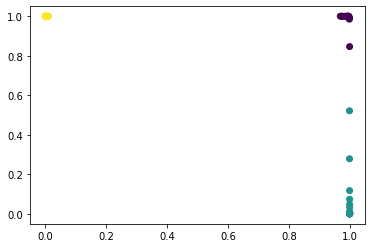

In [20]:
import matplotlib.pyplot as plt

H = predict_intermediate(W, X_test)

h0 = [ x[0] for x in H ]
h1 = [ x[1] for x in H ]
lbl = [ x.argmax() for x in y_test ]

plt.scatter( h0, h1, c = lbl )
plt.show()

## Treinar e avaliar com tangente hiperbólica

In [ ]:
tanh_flag = True
X_train, X_test, y_train, y_test = prepare_data()
W = initialize_weights( [4, 2, 3] )

W = train( W, X_train, y_train, eta=0.5, epochs = 1000, epsilon = 0.01 )
print( 'Train accuracy:', evaluate( W, X_train, y_train ) )
print( 'Test accuracy:', evaluate( W, X_test, y_test ) )

Epoch: 0, mse: 0.308194
Epoch: 200, mse: 0.110955
Epoch: 400, mse: 0.108370
Epoch: 600, mse: 0.079548
Epoch: 800, mse: 0.039050
Epoch: 1000, mse: 0.118644
0.11864402051659724
Train accuracy: 0.97
Test accuracy: 0.96


## Plotar saídas da camada intermediária (tanh)

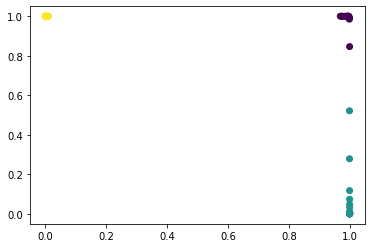

In [21]:
import matplotlib.pyplot as plt

H = predict_intermediate(W, X_test)

h0 = [ x[0] for x in H ]
h1 = [ x[1] for x in H ]
lbl = [ x.argmax() for x in y_test ]

plt.scatter( h0, h1, c = lbl )
plt.show()